# Deep Learning

In [1]:
                                                                                                                                                                                                                                                                                                                                                                                                            # Setup

# Common imports
import tensorflow as tf
import numpy as np

# Plot setup
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# To make notebook output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)


## Activation Functions

In [2]:
def logit(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps)) / (2 * eps)

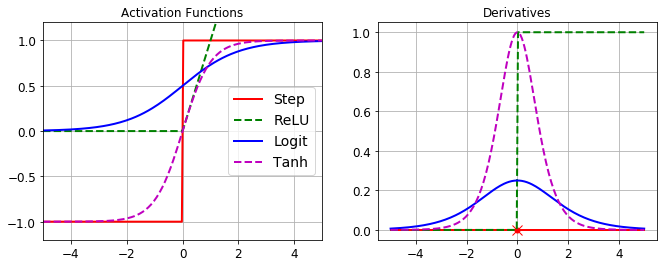

In [3]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=2, label="Step")
plt.plot(z, relu(z), "g--", linewidth=2, label="ReLU")
plt.plot(z, logit(z), "b-", linewidth=2, label="Logit")
plt.plot(z, np.tanh(z), "m--", linewidth=2, label="Tanh")
plt.axis([-5, 5, -1.2, 1.2])
plt.grid(True)
plt.title("Activation Functions")
plt.legend(loc="center right", fontsize=14)

plt.subplot(122)
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=2, label="Step")
plt.plot(z, derivative(relu, z), "g--", linewidth=2, label="ReLU")
plt.plot(z, derivative(logit, z), "b-", linewidth=2, label="Logit")
plt.plot(z, derivative(np.tanh, z), "m--", linewidth=2, label="Tanh")
plt.grid(True)
plt.title("Derivatives")
plt.show()

## Vanishing/Exploding gradients problem - 
## Solution 1 - Use Xavier and He initializations

In [4]:
reset_graph()

n_inputs = 28 * 28 # MNIST
n_hidden1 = 300
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
he_init = tf.contrib.layers.variance_scaling_initializer()
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, kernel_initializer=he_init, name="hidden1")

## Solution 2 - Use Non Saturating Activation Functions

### Leaky Rectified Linear Unit
### Exponential Linear Unit
$ \operatorname{ELU}_\alpha(z) = \begin{cases} \alpha(\exp(z) - 1) & \text{if } z < 0\\ z & if z \ge 0 \end{cases} $
### Scaled Exponential Linear Unit

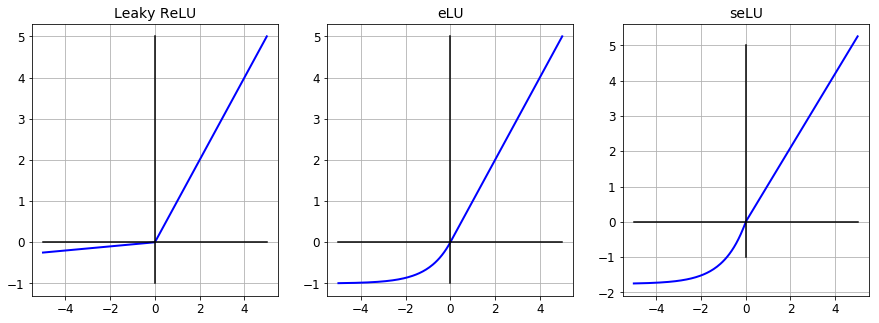

In [5]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

def selu(z,
         scale=1.0507009873554804934193349852946,
         alpha=1.6732632423543772848170429916717):
    return scale*elu(z, alpha)

z = np.linspace(-5, 5, 200)

plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.title("Leaky ReLU", fontsize=14)
plt.plot([-5, 5], [0, 0], "k-")
plt.plot([0, 0], [-1, 5], "k-")
plt.grid(True)

plt.subplot(132)
plt.plot(z, elu(z), "b-", linewidth=2)
plt.title("eLU", fontsize=14)
plt.plot([-5, 5], [0, 0], "k-")
plt.plot([0, 0], [-1, 5], "k-")
plt.grid(True)

plt.subplot(133)
plt.plot(z, selu(z), "b-", linewidth=2)
plt.title("seLU", fontsize=14)
plt.plot([-5, 5], [0, 0], "k-")
plt.plot([0, 0], [-1, 5], "k-")
plt.grid(True)


plt.show()

## Training a neural net on MNIST with seLU

In [10]:
import tensorflow as tf
import numpy as np
import os
from datetime import datetime

# Load the data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data")

# Validation set for early stopping
X_valid = mnist.validation.images
y_valid = mnist.validation.labels

tf.reset_default_graph()

# Construction Phase
# 1) Specify the number of input, hidden, output layers
n_inputs = 28*28 # 1 feature per pixel
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

# 2) Use placeholders to represent the training and target data
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

# 3) Create the different layers of the neural network
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1", activation=tf.nn.selu)
    hidden2 = tf.layers.dense(hidden1, n_hidden2, name="hidden2", activation=tf.nn.selu)
    logits = tf.layers.dense(hidden2, n_outputs, name="logits")

# 4) Define the cost function i.e. the cross-entropy used to train the network
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    # Overall loss of the network
    loss = tf.reduce_mean(xentropy, name="loss")
    # Visualize loss
    loss_summary = tf.summary.scalar("log_loss", loss)
    
# 5) Define the Gradient Descent Optimizer to minimize the cost function
learning_rate = 0.01
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

# 6) Model evaluation criteria - Accuracy
with tf.name_scope("eval"):
    # Determine if the network's prediction are correct - the highest logit corresponds to the target class
    correct = tf.nn.in_top_k(logits, y, 1)
    # Overall accuracy of the network
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    # Visualize accuracy
    accuracy_summary = tf.summary.scalar("accuracy", accuracy)
    
# 7) Initializer and Saver
init = tf.global_variables_initializer()
saver = tf.train.Saver()
    

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [11]:
# Function to define log directory for tensorboard
def log_dir(prefix=""):
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    root_dir = "tf_logs"
    if prefix:
        prefix += "-"
    name = prefix + "run-" + now
    return "{}/{}/".format(root_dir, name)

# Log dir for DNN MNIS SELU
logdir = log_dir("dnn_mnist_selu")

# File Writer to write logs for tensorboard 
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [14]:
# Execution Phase
# Parameters
n_epoch = 40
batch_size = 50
epoch_without_progess = 0
max_epoch_without_progress = 50
best_loss = np.infty

# Checkpoint and final model paths
checkpoint_path = "/tmp/dnn_mnist_selu.ckpt"
checkpoint_epoch_path = checkpoint_path + ".epoch"
final_model_path = "./dnn_mnist_selu/final"

# Initialization scheme for selu
means = mnist.train.images.mean(axis=0, keepdims=True)
stds = mnist.train.images.std(axis=0, keepdims=True) + 1e-10

with tf.Session() as sess:
    if os.path.isfile(checkpoint_epoch_path):
        # If checkpoint file exits load the epoch number and restore the model
        with open(checkpoint_epoch_path, "rb") as f:
            start_epoch = int(f.read())
        print("Training interrupted. Continuing training at epoch:", start_epoch)
        saver.restore(sess, checkpoint_path)
    else:
        # No checkpoint file
        start_epoch = 0
        sess.run(init)
    
    for epoch in range(start_epoch, n_epoch):
        for _ in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch_scaled = (X_batch - means) / stds
            sess.run(training_op, feed_dict={X:X_batch_scaled, y:y_batch})
            X_valid_scaled = (X_valid - means) / stds
            accuracy_val, accuracy_str, loss_val, loss_str = sess.run([accuracy, accuracy_summary, loss, loss_summary],
                                                                     feed_dict={X:X_valid_scaled, y:y_valid})
            file_writer.add_summary(accuracy_str, epoch)
            file_writer.add_summary(loss_str, epoch)
            
        if epoch % 5 == 0:
            print("Epoch:", epoch,
                 "\tValidation Accuracy: {:.3f}%".format(accuracy_val * 100),
                 "\tLoss: {:.5f}".format(loss_val))
            saver.save(sess, checkpoint_path)
            with open(checkpoint_epoch_path, "wb") as f:
                f.write(b"%d" % (epoch + 1))

            if loss_val < best_loss:
                saver.save(sess, final_model_path)
                best_loss = loss_val
            else:
                epoch_without_progess += 5
                if epoch_without_progess > max_epoch_without_progress:
                    print("Early Stopping")
                    break


Epoch: 0 	Validation Accuracy: 92.660% 	Loss: 29360.67773
Epoch: 5 	Validation Accuracy: 95.560% 	Loss: 22403.18945
Epoch: 10 	Validation Accuracy: 96.160% 	Loss: 25900.76562
Epoch: 15 	Validation Accuracy: 96.420% 	Loss: 27031.75586
Epoch: 20 	Validation Accuracy: 96.680% 	Loss: 29864.58203
Epoch: 25 	Validation Accuracy: 96.760% 	Loss: 29917.55469
Epoch: 30 	Validation Accuracy: 96.780% 	Loss: 32449.71289
Epoch: 35 	Validation Accuracy: 96.880% 	Loss: 33669.51953


In [13]:
os.remove(checkpoint_epoch_path)

## Solution 3 - Batch Normalization

In [28]:
# Common imports
import tensorflow as tf
import numpy as np
import os
from datetime import datetime
from functools import partial

# Load the data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data")

reset_graph()

# Parameters
batch_norm_momentum = 0.9
learning_rate = 0.01

# Construction Phase
# 1) Specify the number of input, hidden, and output layers
n_inputs = 28*28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

# 2) Create the placeholders for the training, target, and batch_norm flag
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")
# Flag to inform batch_norm function to use the mini-batch's mean and SD or the running avg that it keeps a track of
training = tf.placeholder_with_default(False, shape=(), name="training")

# 3) Create the layers of the network
with tf.name_scope("dnn"):
    he_init = tf.contrib.layers.variance_scaling_initializer()
    
    # Batch normalization layer - handles centering, normalizing, scaling, shifting of inputs
    my_batch_norm_layer = partial(
        tf.layers.batch_normalization,
        training=training,
        momentum=batch_norm_momentum)
    
    # Dense layer
    my_dense_layer = partial(
        tf.layers.dense, 
        kernel_initializer=he_init)
    
    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    # To run batch norm before each hidden layer's activation function,
    # the activation is applied manually after batch norm layer
    bn1 = tf.nn.elu(my_batch_norm_layer(hidden1))
    hidden2 = my_dense_layer(bn1, n_hidden2, name="hidden2")
    bn2 = tf.nn.elu(my_batch_norm_layer(hidden2))
    logits_before_bn = my_dense_layer(bn2, n_outputs, name="outputs")
    logits = my_batch_norm_layer(logits_before_bn)
    
# 4) Define the cost function - i.e. the cross-entropy used to train the network
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    
# 5) Define the GradientDescentOptimizer to minimize the cost function
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    training_op = optimizer.minimize(loss)
    
# 6) Model evaluation criteria - accuracy
with tf.name_scope("eval"):
    # Determine if the network's predictions are correct - the highest logit corresponds to the target class
    correct = tf.nn.in_top_k(logits, y, 1)
    # Coumpute the overall network's accuracy
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    # Visualize accuracy
    accuracy_summary = tf.summary.scalar("accuracy", accuracy)

# 7) Initializer and Saver
init = tf.global_variables_initializer()
saver = tf.train.Saver()

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [29]:
# DNN MNIST BN Log entry
logdir = log_dir("dnn_mnist_bn")

# File writer for tensorboard
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [30]:
# Execution Phase

# Get the update operations from the UPDATE_OPS needed by batch norm
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

# Parameters
n_epochs = 20
batch_size = 200

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs):
        for _ in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run([training_op, extra_update_ops],
                    feed_dict={training:True, X:X_batch, y:y_batch})
        accuracy_val, accuracy_str = sess.run([accuracy, accuracy_summary], feed_dict={X:mnist.test.images, y:mnist.test.labels})
        file_writer.add_summary(accuracy_str, epoch)
        print("Epoch:", epoch,
             "\tTest Accuracy:", accuracy_val)
    saver.save(sess, "./dnn_mnist_bn/my_dnn_mnist_bn.ckpt")

Epoch: 0 	Test Accuracy: 0.8678
Epoch: 1 	Test Accuracy: 0.8941
Epoch: 2 	Test Accuracy: 0.9116
Epoch: 3 	Test Accuracy: 0.9222
Epoch: 4 	Test Accuracy: 0.9292
Epoch: 5 	Test Accuracy: 0.9336
Epoch: 6 	Test Accuracy: 0.94
Epoch: 7 	Test Accuracy: 0.9427
Epoch: 8 	Test Accuracy: 0.945
Epoch: 9 	Test Accuracy: 0.9479
Epoch: 10 	Test Accuracy: 0.9516
Epoch: 11 	Test Accuracy: 0.9538
Epoch: 12 	Test Accuracy: 0.9571
Epoch: 13 	Test Accuracy: 0.9565
Epoch: 14 	Test Accuracy: 0.959
Epoch: 15 	Test Accuracy: 0.961
Epoch: 16 	Test Accuracy: 0.9606
Epoch: 17 	Test Accuracy: 0.9623
Epoch: 18 	Test Accuracy: 0.9639
Epoch: 19 	Test Accuracy: 0.9637
